## Importing modules

In [40]:
import os
import time
from pathlib import Path
from PIL import Image

import cv2
import numpy as np
import pandas as pd
from openvino.inference_engine import IECore
from openvino.runtime import Core
import tensorflow as tf


%matplotlib inline
from matplotlib import pyplot as plt
from notebook_utils import download_file

print("Imported Python modules successfully.")

Imported Python modules successfully.


## Serializing TF Keras model into SavedModel format.

In [2]:
model = tf.keras.models.load_model('model.h5')
tf.saved_model.save(model,'endoscopy_model')

INFO:tensorflow:Assets written to: endoscopy_model/assets


## Convert the model to ir model format and save it.

In [42]:
### Saving to Floating point type 16

!mo \
--saved_model_dir endoscopy_model \
--input_shape=[1,100,100,3] \
--output_dir models/endoscopy/FP16 \
--scale 256 \
--mean_values [127,127,127] \
--data_type FP16 

usage: main.py [options]
main.py: error: unrecognized arguments: --compress_to_fp16


In [13]:
### Saving to Floating point type 32

!mo \
--saved_model_dir endoscopy_model \
--input_shape=[1,100,100,3] \
--output_dir models/endoscopy/FP32 \
--scale 256 \
--mean_values [127,127,127] \
--data_type FP32

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/u191360/Reference-samples/iot-devcloud/openvino-dev-latest/tutorials/trial/dermnet/models/endoscopy/FP32
	- IR output name: 	saved_model
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,100,100,3]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	[127,127,127]
	- Scale values: 	Not specified
	- Scale factor: 	256.0
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model conversion into IR: 	False
	- Force th

In [14]:
 # find all resulting IR files
!echo "\nAll IR files that were created:"
!find ./models -name "*.xml" -o -name "*.bin"

\nAll IR files that were created:
./models/endoscopy/FP16/saved_model.bin
./models/endoscopy/FP16/saved_model.xml
./models/endoscopy/FP32/saved_model.bin
./models/endoscopy/FP32/saved_model.xml


In [16]:
!mo --help

usage: main.py [options]

optional arguments:
  -h, --help            show this help message and exit
  --framework {caffe,kaldi,paddle,tf,mxnet,onnx}
                        Name of the framework used to train the input model.

Framework-agnostic parameters:
  --input_model INPUT_MODEL, -w INPUT_MODEL, -m INPUT_MODEL
                        Tensorflow*: a file with a pre-trained model (binary
                        or text .pb file after freezing). Caffe*: a model
                        proto file with model weights
  --model_name MODEL_NAME, -n MODEL_NAME
                        Model_name parameter passed to the final create_ir
                        transform. This parameter is used to name a network in
                        a generated IR and output .xml/.bin files.
  --output_dir OUTPUT_DIR, -o OUTPUT_DIR
                        Directory that stores the generated IR. By default, it
                        is the directory from where the Model Optimizer is
                  

In [ ]:
# Convert the model to ir model format and save it.
ir_model_path = Path("model/flower")
ir_model_path.mkdir(parents=True, exist_ok=True)
ir_model = mo.convert_model(saved_model_dir=saved_model_dir, input_shape=[1,180,180,3], compress_to_fp16=True)
serialize(ir_model, str(ir_model_path / "flower_ir.xml"))

In [17]:
def pre_process_image(imagePath, img_height=100):
    # Model input format
    n, h, w, c = [1, img_height, img_height, 3]
    image = Image.open(imagePath)
    image = image.resize((h, w), resample=Image.BILINEAR)

    # Convert to array and change data layout from HWC to CHW
    image = np.array(image)
    input_image = image.reshape((n, h, w, c))

    return input_image

In [29]:
class_names = pd.read_csv('labels.txt', header=None)[0].tolist()
class_names

['dyed-lifted-polyps',
 'dyed-resection-margins',
 'esophagitis',
 'normal-cecum',
 'normal-pylorus',
 'normal-z-line',
 'polyps',
 'ulcerative-colitis']

In [30]:
ir_model = "models/endoscopy/FP32/saved_model.xml"

In [ ]:
quantized_model = nncf.quantize(
    ir_model,
    calibration_dataset,
    subset_size=1000
)

In [ ]:
compressed_model_dir = Path("model/optimized")
compressed_model_dir.mkdir(parents=True, exist_ok=True)
compressed_model_xml = compressed_model_dir / "flower_ir.xml"
serialize(quantized_model, str(compressed_model_xml))

In [33]:
# Initialize OpenVINO runtime
ie = Core()

# Neural Compute Stick
# compile the model for the CPU (you can choose manually CPU, GPU, MYRIAD etc.)
# or let the engine choose the best available device (AUTO)
# compiled_model = ie.compile_model(model=model, device_name="MYRIAD")
compiled_model = ie.compile_model(model=ir_model, device_name="CPU")

#del ir_model

input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)

'output/Esophageal_ulcer.jpg' already exists.
(1, 100, 100, 3)
{1, 100, 100, 3}
This image most likely belongs to esophagitis with a 14.69 percent confidence.


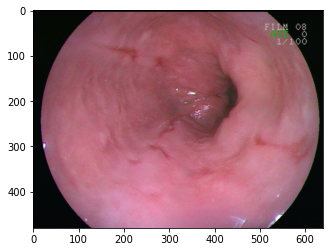

In [41]:
# Run inference on the input image...
inp_img_url = "https://upload.wikimedia.org/wikipedia/commons/1/11/Esophageal_ulcer.jpg"
OUTPUT_DIR = "output"
inp_file_name = f"Esophageal_ulcer.jpg"
file_path = Path(OUTPUT_DIR)/Path(inp_file_name)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Download the image
download_file(inp_img_url, inp_file_name, directory=OUTPUT_DIR)

# Pre-process the image and get it ready for inference.
input_image = pre_process_image(file_path)

print(input_image.shape)
print(input_layer.shape)
res = compiled_model([input_image])[output_layer]

score = tf.nn.softmax(res[0])

# Show the results
image = Image.open(file_path)
plt.imshow(image)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)